In [239]:
# import the most useful packages
%load_ext autoreload
%autoreload 2
import numpy as np 
import matplotlib
import math
import os
from matplotlib import pyplot as plt
import IPython.display as ipd

import librosa
import librosa.display
from glob import glob
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit

try:
    plt.style.use('rossidata')
except:
    sns.set_style("white")
import mediapy as media
import warnings
warnings.filterwarnings("ignore", message="PySoundFile failed. Trying audioread instead.")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [457]:
import tensorflow as tf
import IPython.display as ipd
import keras
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,MaxPooling1D, BatchNormalization,LSTM,Embedding,Masking,TimeDistributed,Input
from sklearn.model_selection import train_test_split
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D,Conv1D,Conv2D
from keras.utils import np_utils
from keras.utils import to_categorical

# Prepping the data

In [217]:
# prepping training data
def mp3tomfcc(file_path, max_pad):
    audio, sample_rate = librosa.core.load(file_path)
    mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=60)
    return mfcc



def mp3toMSG(file_path, max_pad):
    audio, sample_rate = librosa.core.load(file_path)
    MSG = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_fft=1024, hop_length=512, n_mels=80, fmin=75, fmax=3700)
    MSG=np.log10(MSG + 1e-10)

    return MSG


def add_padding(arrays,bonus_padding=10):
    heights,widths=list(zip(*[x.shape for x in arrays]))
    max_height=max(heights)
    max_width=max(widths)

    new_arrays=[]
    for array in arrays:

        pad_width = (max_width - array.shape[1])+bonus_padding
        pad_height = (max_height - array.shape[0])+bonus_padding

        new_array = np.pad(array, pad_width=((bonus_padding, pad_height), (bonus_padding, pad_width)), mode='constant')
        new_arrays.append(new_array)
        
    heights,widths=list(zip(*[x.shape for x in new_arrays]))

    assert len(set(heights))==1, print('not all the same size!')
    assert len(set(widths))==1, print('not all the same size!')
    return new_arrays

In [226]:
# just ma data
#for file in glob('../data/tone_perfect_mp3/*.mp3')

files=glob('../data/tone_perfect_mp3/ma*.mp3')
substring_list=['ma1','ma2','ma3','ma4']
mfccs=[]
MSGs=[]
labels=[]
full_labels=[]

for file in files:
    if any(map(file.__contains__, substring_list)):
        mfccs.append(mp3tomfcc(file, 60))
        MSGs.append(mp3toMSG(file, 60))

        label=file.split('/')[-1].split('_')[0][-1]
        labels.append(int(label))
        
        # full labels 
        full_labels.append(file.split('/')[-1].replace('_MP3.mp3',''))

MSGs=add_padding(MSGs,bonus_padding=2)
mfccs=add_padding(mfccs,bonus_padding=2)

mfccs,MSGs,labels,full_labels=list(zip(*sorted(zip(mfccs,MSGs,labels,full_labels), key=lambda x: x[2])))


In [228]:
print([x.shape for x in MSGs])


[(84, 50), (84, 50), (84, 50), (84, 50), (84, 50), (84, 50), (84, 50), (84, 50), (84, 50), (84, 50), (84, 50), (84, 50), (84, 50), (84, 50), (84, 50), (84, 50), (84, 50), (84, 50), (84, 50), (84, 50), (84, 50), (84, 50), (84, 50), (84, 50)]


In [229]:
mfcc_dict=dict(zip(full_labels, mfccs))

ma1_FV3,ma1_MV2,ma1_FV2,ma1_MV3,ma1_MV1,ma1_FV1
ma2_FV1,ma2_MV1,ma2_MV3,ma2_FV2,ma2_MV2,ma2_FV3
ma3_MV1,ma3_FV1,ma3_FV3,ma3_MV2,ma3_FV2,ma3_MV3
ma4_FV2,ma4_MV3,ma4_FV3,ma4_MV2,ma4_FV1,ma4_MV1

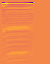
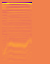
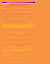
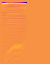
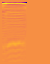
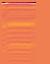
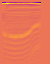
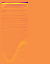
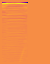
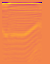
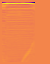
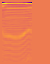
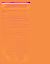
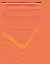
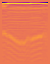
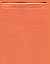
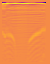
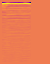
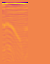
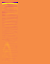
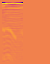
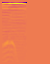
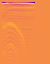
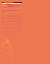

In [230]:
media.show_images(mfcc_dict,columns=6,  border=True, height=100,cmap='plasma')

ma1_FV3,ma1_MV2,ma1_FV2,ma1_MV3,ma1_MV1,ma1_FV1
ma2_FV1,ma2_MV1,ma2_MV3,ma2_FV2,ma2_MV2,ma2_FV3
ma3_MV1,ma3_FV1,ma3_FV3,ma3_MV2,ma3_FV2,ma3_MV3
ma4_FV2,ma4_MV3,ma4_FV3,ma4_MV2,ma4_FV1,ma4_MV1

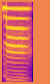
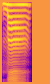
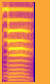
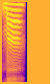
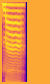
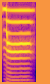
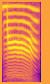
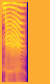
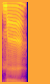
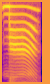
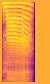
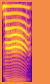
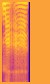
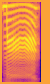
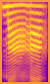
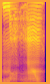
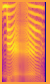
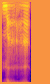
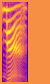
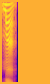
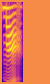
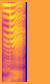
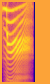
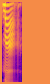

In [231]:
MSG_dict=dict(zip(full_labels, MSGs))
media.show_images(MSG_dict,columns=6,  border=True, height=100,cmap='plasma')



,,,

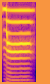
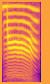
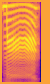
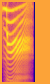

In [294]:
select_images=[MSG_dict['ma1_FV1'],MSG_dict['ma2_FV1'],MSG_dict['ma3_FV1'],MSG_dict['ma4_FV1']]

media.show_images(select_images, height=200,cmap='plasma',border=True)


In [233]:
np.save('../data/ma_data/ma_mfccs.npy', mfccs)
np.save('../data/ma_data/ma_MSGs.npy', MSGs)


In [234]:
np.save('../data/ma_data/ma_labels.npy', labels)


# visualize encoded data

In [96]:
mfccs = np.load('../data/ma_data/ma_sound_arrays.npy').tolist()


,,,
,,,
,,,
,,,
,,,
,,,

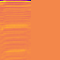
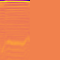
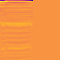
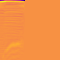
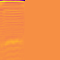
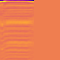
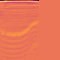
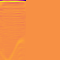
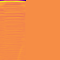
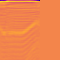
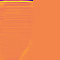
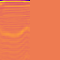
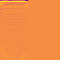
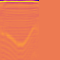
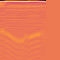
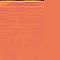
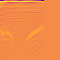
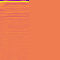
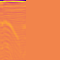
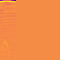
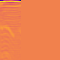
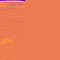
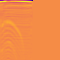
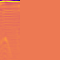

In [100]:


media.show_images(mfccs,columns=4,  border=True, height=100,cmap='plasma')

# CNN experiments

In [235]:
def get_cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(48, kernel_size=(2, 2), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(120, kernel_size=(2, 2), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model

mfccs = np.load('../data/ma_data/ma_MSGs.npy').tolist()
mfccs = np.asarray(mfccs)
labels = np.load('../data/ma_data/ma_labels.npy')

dim_1 = mfccs.shape[1]
dim_2 = mfccs.shape[2]
channels = 1
classes = 4

X = mfccs
print(X.shape)
X = X.reshape((mfccs.shape[0], dim_1, dim_2, channels))
print(X.shape)
y = labels
input_shape = (dim_1, dim_2, channels)


(24, 84, 50)
(24, 84, 50, 1)


In [236]:
onehot_y = np.zeros((y.size, y.max()))
onehot_y[np.arange(y.size),y-1] = 1

In [244]:
model = get_cnn_model(input_shape, classes)

# 
#sss = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=0)
split=StratifiedShuffleSplit(n_splits=1, test_size=0.16, random_state=9)
split.get_n_splits(X,onehot_y)

for idx1,idx2 in split.split(X,y):
    X_train,X_test=X[idx1],X[idx2]
    y_train,y_test=onehot_y[idx1],onehot_y[idx2]
    
    
history = model.fit(X_train, y_train, epochs=200, verbose=0,validation_data=(X_test, y_test))

In [245]:
model.summary()


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 83, 49, 32)        160       
_________________________________________________________________
batch_normalization_33 (Batc (None, 83, 49, 32)        128       
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 82, 48, 48)        6192      
_________________________________________________________________
batch_normalization_34 (Batc (None, 82, 48, 48)        192       
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 81, 47, 120)       23160     
_________________________________________________________________
batch_normalization_35 (Batc (None, 81, 47, 120)       480       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 40, 23, 120)     

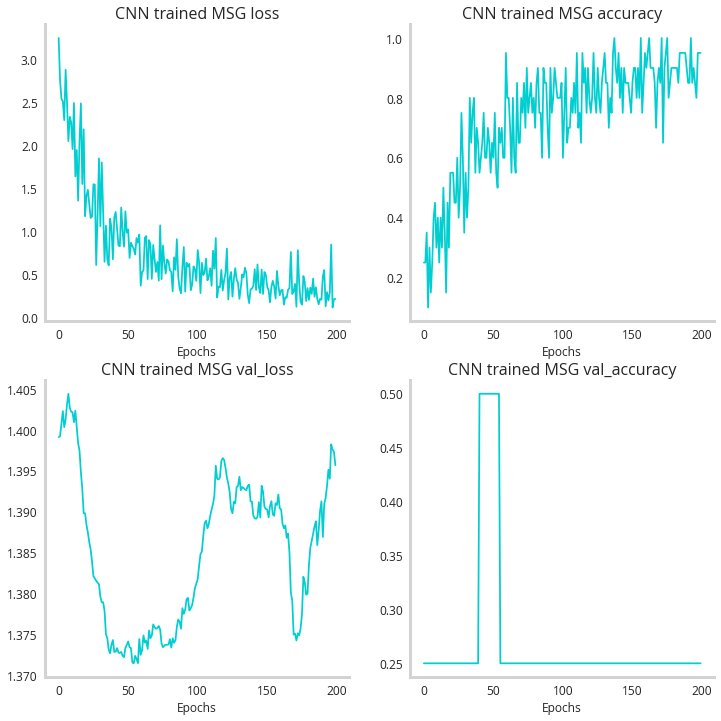

In [238]:
# summarized plots
def performance_plots(history,label='CNN',out_target='figures/cnn_performance.png'):
    fig,ax=plt.subplots(2,2,figsize=(12,12))

    ax[0,0].plot(history.history['loss'])
    ax[0,0].set_title(f'{label} loss')
    ax[0,0].set_xlabel('Epochs')
    
    
    ax[0,1].plot(history.history['accuracy'])
    ax[0,1].set_title(f'{label} accuracy')
    ax[0,1].set_xlabel('Epochs')

    ax[1,0].plot(history.history['val_loss'])
    ax[1,0].set_title(f'{label} val_loss')
    ax[1,0].set_xlabel('Epochs')

    ax[1,1].plot(history.history['val_accuracy'])
    ax[1,1].set_title(f'{label} val_accuracy')
    ax[1,1].set_xlabel('Epochs')

    fig.savefig(out_target,dpi=300,bbox_inches='tight')
    
performance_plots(history,'CNN trained MSG','figures/cnn_msg_performance.png')

# LSTM model

In [487]:
input_arrays = np.load('../data/ma_data/ma_mfccs.npy').tolist()
input_arrays = np.asarray(input_arrays)
labels = np.load('../data/ma_data/ma_labels.npy')

dim_1 = input_arrays.shape[1]
dim_2 = input_arrays.shape[2]
channels = 1
classes = 4

X = input_arrays
print(X.shape)
X = X.reshape((input_arrays.shape[0],dim_2, dim_1 ))
print(X.shape)
y = labels
input_shape = (dim_2,dim_1,channels)



(24, 64, 50)
(24, 50, 64)


In [488]:
# Building RNN
def get_LSTM_model(input_shape, num_classes):
    features=input_shape[1]
    time_steps=input_shape[0]

    look_back=32

    model = Sequential()

    model.add(LSTM(look_back, input_shape=(time_steps,features)))
    model.add(Dense(128, activation='relu'))

    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer='adam',
                  metrics=['accuracy'])
    return model
    


In [489]:
model = get_LSTM_model(input_shape, classes)
print(input_shape)
print(classes)
model.summary()

(50, 64, 1)
4
Model: "sequential_138"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_55 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_100 (Dense)            (None, 128)               4224      
_________________________________________________________________
dense_101 (Dense)            (None, 4)                 516       
Total params: 17,156
Trainable params: 17,156
Non-trainable params: 0
_________________________________________________________________


In [490]:
model = get_LSTM_model(input_shape, classes)

# 
#sss = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=0)
split=StratifiedShuffleSplit(n_splits=1, test_size=0.16, random_state=88)
split.get_n_splits(X,onehot_y)

for idx1,idx2 in split.split(X,y):
    X_train,X_test=X[idx1],X[idx2]
    y_train,y_test=onehot_y[idx1],onehot_y[idx2]
    
    
history = model.fit(X_train, y_train, epochs=20, verbose=0,validation_data=(X_test, y_test))

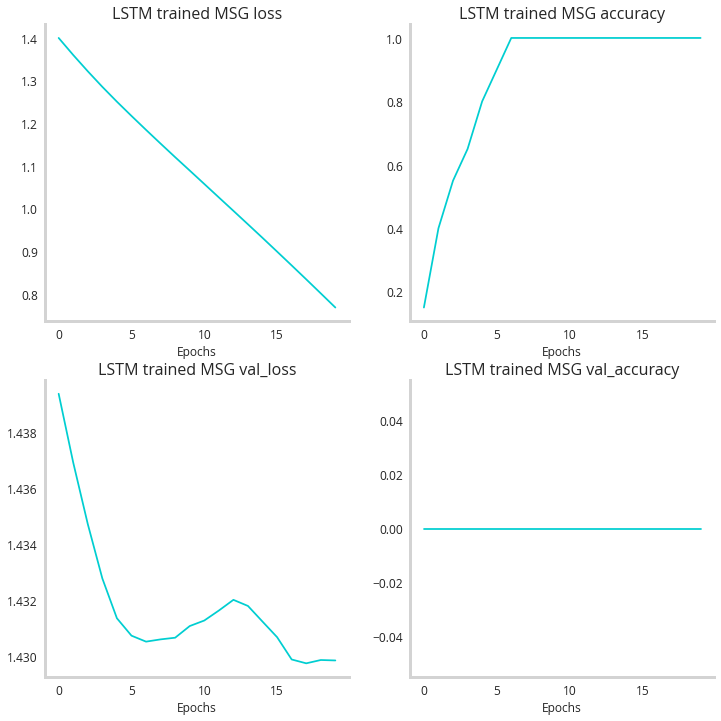

In [491]:
performance_plots(history,'LSTM trained MSG','figures/lstm_msg_performance.png')

In [432]:
# LSTM /CNN model
def get_LSTM_CNN_model(input_shape, num_classes):
    n_features=input_shape[1]
    time_steps=input_shape[0]
    filters=16

    cnn = Sequential()
    cnn.add(Conv2D(64, (2,2), activation='relu'))
    
    cnn.add(BatchNormalization())
    cnn.add(Conv2D(48, kernel_size=(2, 2), activation='relu'))
    cnn.add(BatchNormalization())
    cnn.add(Conv2D(120, kernel_size=(2, 2), activation='relu'))
    cnn.add(BatchNormalization())
    cnn.add(MaxPooling2D(pool_size=(2, 2)))
    cnn.add(Dropout(0.25))
    cnn.add(Flatten())
    cnn.add(Dense(1))
    
    model = Sequential()
    
    model.add(
    TimeDistributed(cnn,
        input_shape = (None,time_steps, n_features,1)))
    
    
    
    model.add(LSTM(32,input_shape=(None,time_steps,n_features)))
    
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [492]:
def alt_lstmcnn(input_shape,num_classes):
    n_features=input_shape[1]
    time_steps=input_shape[0]
    
    model = Sequential()

    model.add(Input(shape=(time_steps, n_features)))
    model.add(Conv1D(filters=32,
                   kernel_size=3,
                   strides=1,
                   activation='relu',
                   padding='same'))
    model.add(MaxPooling1D(data_format='channels_first',pool_size=(4)))
    model.add(LSTM(8))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [493]:
model = alt_lstmcnn(input_shape, classes)
split=StratifiedShuffleSplit(n_splits=1, test_size=0.16, random_state=88)
split.get_n_splits(X,onehot_y)

for idx1,idx2 in split.split(X,y):
    X_train,X_test=X[idx1],X[idx2]
    y_train,y_test=onehot_y[idx1],onehot_y[idx2]
    
    
history = model.fit(X_train, y_train, epochs=70, verbose=0,validation_data=(X_test, y_test))

In [494]:
model.summary()

Model: "sequential_140"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 50, 32)            6176      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 50, 8)             0         
_________________________________________________________________
lstm_57 (LSTM)               (None, 8)                 544       
_________________________________________________________________
dense_104 (Dense)            (None, 4)                 36        
Total params: 6,756
Trainable params: 6,756
Non-trainable params: 0
_________________________________________________________________


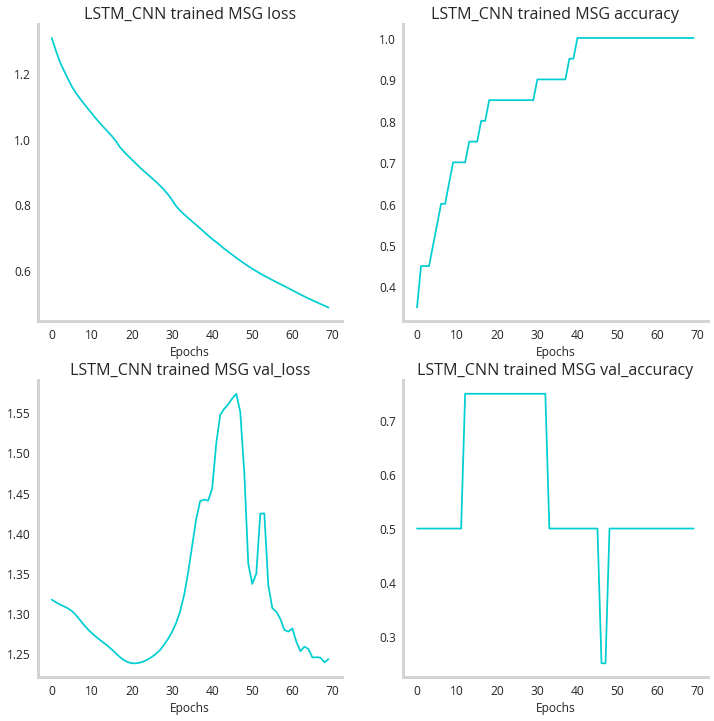

In [495]:
performance_plots(history,'LSTM_CNN trained MSG','figures/lstm_cnn_msg_performance.png')

/Users/nicholas.rossi/miniconda3/envs/tinghaole/lib/python3.6/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Confusion matrix, without normalization
[[0 0 0 1]
 [0 1 0 0]
 [1 0 0 0]
 [1 0 0 0]]


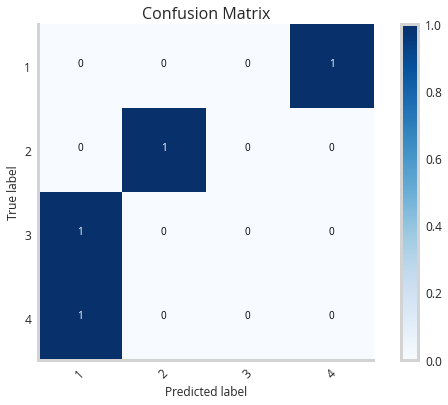

In [49]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix


y_pred = model.predict(X_test).ravel()
y_pred_labels=model.predict_classes(X_test)
y_true_labels = np.argmax(y_test, axis=1)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = confusion_matrix(y_true_labels, y_pred_labels)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cm, classes=[1, 2, 3, 4],
                      title='Confusion Matrix')

In [107]:
y_true_labels

array([3, 2, 0, 1])

In [111]:

np.argmax(y_pred)

0

In [112]:
model.predict_classes(X_test)

/Users/nicholas.rossi/miniconda3/envs/tinghaole/lib/python3.6/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([0, 1, 3, 3])